In [13]:
# Load the main libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Load the data.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Prepare data for neural network.
y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)
X_train = X_train/255.0
X_test = test/255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)



In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [6]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose = 0 )
styles = [':', '-.', '--', '-', ':', '-.', '--', '-', ':', '-.', '--', '-' ]

In [7]:
from tensorflow.keras import models, layers

In [16]:
# How many convolution-subsampling pairs?

nets = 3
model = [0]* nets

for j in range(nets):
    model[j] = models.Sequential()
    model[j].add( layers.Conv2D( 24, kernel_size = 5, padding='same', activation = 'relu', input_shape=(28,28,1) ) )
    model[j].add( layers.MaxPool2D() )
    if j > 0:
        model[j].add( layers.Conv2D(48, kernel_size=5, padding='same', activation = 'relu'))
        model[j].add( layers.MaxPool2D() )
    if j > 1:
        model[j].add( layers.Conv2D(64, kernel_size=5, padding='same', activation = 'relu'))
        model[j].add( layers.MaxPool2D() )
    model[j].add( layers.Flatten() )
    model[j].add( layers.Dense(256, activation = 'relu') )
    model[j].add( layers.Dense(10, activation = 'softmax'))
    model[j].compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [9]:
from sklearn.model_selection import train_test_split

In [17]:
# Experiment 1:
# How many convolution-subsampling pairs?
# We test 1 vs 2 vs 3 and don't test
# anymore because the images become too small
# after 3.

# Conclusion:
# 2 Convolution-subsampling pairs
# works as well as 3 but is less
# expensive to train.

# Create Validation Set
X_train2, X_val2, y_train2, y_val2 = train_test_split( X_train, y_train, test_size = 1./3. )

# Train networks
history = [0] * nets
names = ['(C-P)x1', '(C-P)x2', '(C-P)x3']
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2, y_train2, batch_size=80, epochs = epochs,
                             validation_data=(X_val2,y_val2), callbacks = [annealer], verbose = 0 )
    print( 'CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}'.format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) )) 

CNN (C-P)x1: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.98807
CNN (C-P)x2: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99057
CNN (C-P)x3: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99221


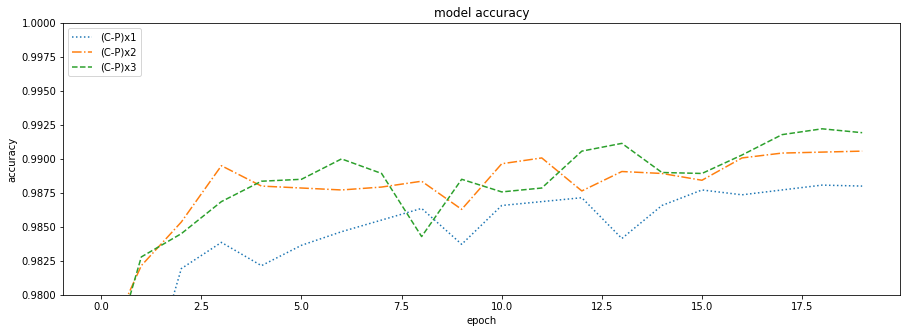

In [18]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [19]:
# Experiment 2
# How many feature maps?

nets = 6
model = [0]*nets
for j in range(6):
    model[j] = models.Sequential()
    model[j].add( layers.Conv2D( j*8+8, kernel_size=5, activation='relu', input_shape=(28,28,1) ) )
    model[j].add( layers.MaxPool2D() )
    
    model[j].add( layers.Conv2D( j*16 + 16, kernel_size=5, activation='relu') )
    model[j].add( layers.MaxPool2D() )
    
    model[j].add( layers.Flatten() )
    model[j].add( layers.Dense(256, activation = 'relu'))
    model[j].add( layers.Dense(10, activation = 'softmax'))
    model[j].compile( optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 1./3.)

history = [0]*nets
names = ['8 maps', '16 maps', '24 maps', '32 maps', '48 maps', '64 maps']
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,y_train2, batch_size=80, epochs=epochs, 
                              validation_data = (X_val2, y_val2), callbacks = [annealer],
                             verbose = 0)
    print( 'CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy = {3:.5f}'.format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

CNN 8 maps: Epochs=20, Train accuracy=0.99986, Validation accuracy = 0.98714
CNN 16 maps: Epochs=20, Train accuracy=0.99996, Validation accuracy = 0.98907
CNN 24 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy = 0.98957
CNN 32 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy = 0.99036
CNN 48 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy = 0.99036
CNN 64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy = 0.99021


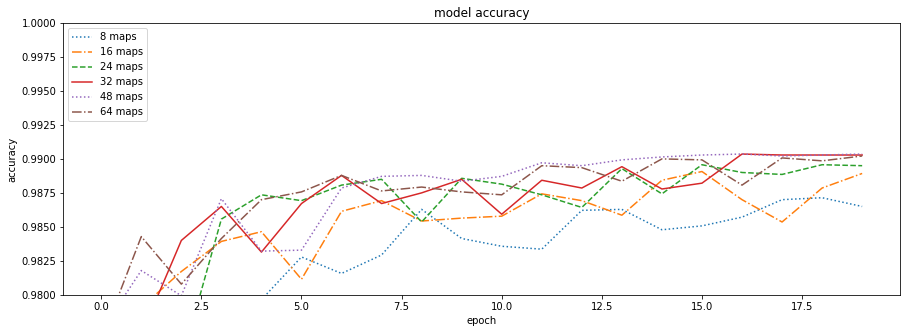

In [23]:
plt.figure( figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [24]:
# Experiment 3
# How large of a dense layer?
# 0, 32, 64, 128, 256, 512, 1024, 2048

nets = 8
model = [0]*nets

for j in range(8):
    model[j] = models.Sequential()
    model[j].add( layers.Conv2D( 32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
    model[j].add( layers.MaxPool2D())
    
    model[j].add( layers.Conv2D(64, kernel_size=5, activation='relu'))
    model[j].add( layers.MaxPool2D())
    model[j].add( layers.Flatten())
    if j > 0:
        model[j].add( layers.Dense(2**(j+4), activation = 'relu'))
    model[j].add( layers.Dense(10, activation='softmax'))
    model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
X_train2, X_val2, y_train2, y_val2 = train_test_split( X_train, y_train, test_size = 1./3. )

history = [0] * nets
names = ['0N', '32N', '64N', '128N', '256N', '512N', '1024N', '2048N']
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2, y_train2, batch_size=80, epochs=epochs,
                             validation_data = (X_val2, y_val2), callbacks = [annealer],
                             verbose=0)
    print( "CNN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

CNN 0N: Epochs=20, Train Accuracy=0.99993, Validation accuracy=0.98907
CNN 32N: Epochs=20, Train Accuracy=0.99964, Validation accuracy=0.98936
CNN 64N: Epochs=20, Train Accuracy=0.99982, Validation accuracy=0.98971
CNN 128N: Epochs=20, Train Accuracy=0.99993, Validation accuracy=0.99029
CNN 256N: Epochs=20, Train Accuracy=1.00000, Validation accuracy=0.99093
CNN 512N: Epochs=20, Train Accuracy=1.00000, Validation accuracy=0.99100
CNN 1024N: Epochs=20, Train Accuracy=1.00000, Validation accuracy=0.99150
CNN 2048N: Epochs=20, Train Accuracy=1.00000, Validation accuracy=0.99200


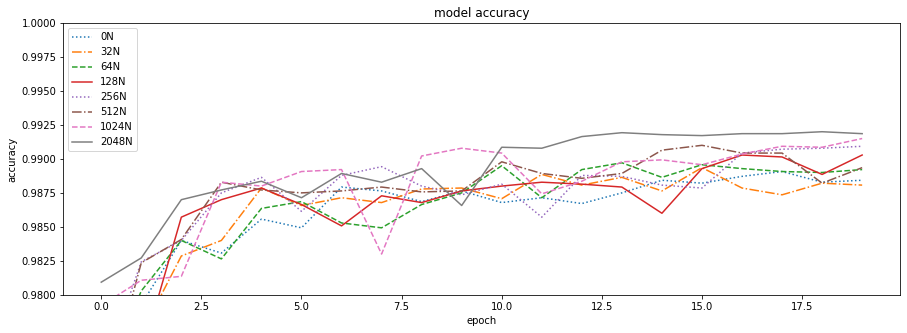

In [26]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i] )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [28]:
# Experiment 4
# How much dropout?
# 0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%

nets = 8
model = [0] * nets

for j in range(8):
    model[j] = models.Sequential()
    model[j].add( layers.Conv2D( 32, kernel_size=5, activation='relu', input_shape=(28,28,1) ))
    model[j].add( layers.MaxPool2D())
    model[j].add( layers.Dropout(rate=j*0.1))
    model[j].add( layers.Conv2D( 64, kernel_size=5, activation='relu'))
    model[j].add( layers.MaxPool2D())
    model[j].add( layers.Dropout(rate=j*0.1))
    model[j].add( layers.Flatten())
    model[j].add( layers.Dense(128, activation='relu'))
    model[j].add( layers.Dense(10, activation = 'softmax'))
    model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
X_train2, X_val2, y_train2, y_val2 = train_test_split( X_train, y_train, test_size = 1./3. )

history = [0] * nets
names = ['D=0', 'D=0.1', 'D=0.2', 'D=0.3', 'D=0.4', 'D=0.5', 'D=0.6', 'D=0.7']
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2, y_train2, batch_size=80, epochs=epochs,
                             validation_data = (X_val2, y_val2), callbacks = [annealer],
                             verbose=0)
    print( "CNN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

CNN D=0: Epochs=20, Train Accuracy=1.00000, Validation accuracy=0.99071
CNN D=0.1: Epochs=20, Train Accuracy=0.99929, Validation accuracy=0.99121
CNN D=0.2: Epochs=20, Train Accuracy=0.99825, Validation accuracy=0.99157
CNN D=0.3: Epochs=20, Train Accuracy=0.99686, Validation accuracy=0.99193
CNN D=0.4: Epochs=20, Train Accuracy=0.99507, Validation accuracy=0.99179
CNN D=0.5: Epochs=20, Train Accuracy=0.99300, Validation accuracy=0.99214
CNN D=0.6: Epochs=20, Train Accuracy=0.98804, Validation accuracy=0.99179
CNN D=0.7: Epochs=20, Train Accuracy=0.97914, Validation accuracy=0.99121


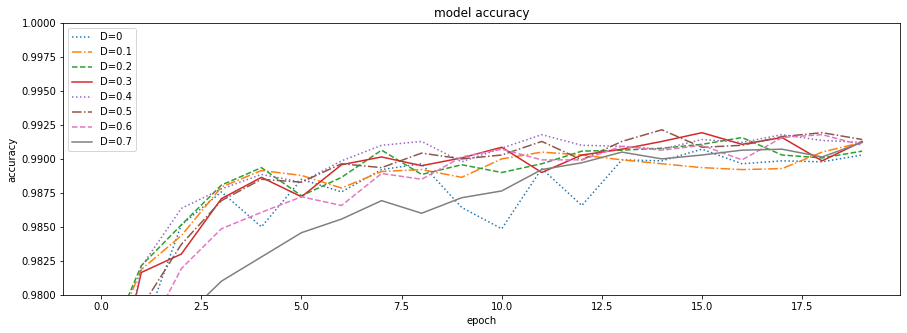

In [30]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i] )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [35]:
# Advanced Features
# Replace '32C5' with '32C3-32C3'
# Replace MaxPooling with convolution layer with strides = 2
# Add batch normalization

nets = 5
model = [0]*nets

j=0
model[j] = models.Sequential()
model[j].add( layers.Conv2D( 32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
model[j].add( layers.MaxPool2D())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Conv2D( 64, kernel_size=5, activation = 'relu'))
model[j].add( layers.MaxPool2D())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Flatten())
model[j].add( layers.Dense(128, activation = 'relu'))
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Dense(10, activation='softmax'))
model[j].compile( optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

j=1
model[j] = models.Sequential()
model[j].add( layers.Conv2D( 32, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model[j].add( layers.Conv2D( 32, kernel_size=3, activation = 'relu'))
model[j].add( layers.MaxPool2D())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Conv2D( 64, kernel_size=3, activation='relu'))
model[j].add( layers.Conv2D( 64, kernel_size=3, activation='relu'))
model[j].add( layers.MaxPool2D())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Flatten())
model[j].add( layers.Dense(128, activation='relu'))
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Dense(10, activation = 'softmax'))
model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

j=2
model[j] = models.Sequential()
model[j].add( layers.Conv2D(32, kernel_size=5, activation='relu', input_shape=(28,28,1)))
model[j].add( layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Conv2D(64, kernel_size=5, activation='relu'))
model[j].add( layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Flatten())
model[j].add( layers.Dense(128, activation='relu'))
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Dense(10, activation='softmax'))
model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

j=3
model[j] = models.Sequential()
model[j].add( layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(32, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Conv2D(64, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(64, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Flatten())
model[j].add( layers.Dense(128, activation='relu'))
model[j].add( layers.Dropout(0.5))
model[j].add( layers.Dense(10, activation='softmax'))
model[j].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

j=4
model[j] = models.Sequential()
model[j].add( layers.Conv2D( 32, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D( 32, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Conv2D(64, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(64, kernel_size=3, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Dropout(0.5))

model[j].add( layers.Flatten())
model[j].add( layers.Dense(128, activation='relu'))
model[j].add( layers.BatchNormalization())
model[j].add( layers.Dropout(0.5))
model[j].add( layers.Dense(10, activation='softmax'))

model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
X_train2, X_val2, y_train2, y_val2 = train_test_split( X_train, y_train, test_size = 0.2 )

history = [0] * nets
names = ['basic', '32C3-32C3', '32C5S2', 'both+BN', 'both+BN+DA']
epochs = 35
for j in range(nets-1):
    history[j] = model[j].fit(X_train2, y_train2, batch_size=80, epochs=epochs,
                             validation_data = (X_val2, y_val2), callbacks = [annealer],
                             verbose=0)
    print( "CNN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy'])))
    
# Create More training images via data augmentation
datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

j = nets-1
history[j] = model[j].fit_generator(datagen.flow(X_train2, y_train2, batch_size=64),
                                   epochs=epochs, steps_per_epoch = X_train2.shape[0]//64, 
                                   validation_data = (X_val2, y_val2), callbacks=[annealer], verbose=0)
print( "CNN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy'])))

CNN basic: Epochs=35, Train Accuracy=0.99024, Validation accuracy=0.99381
CNN 32C3-32C3: Epochs=35, Train Accuracy=0.99351, Validation accuracy=0.99536
CNN 32C5S2: Epochs=35, Train Accuracy=0.99735, Validation accuracy=0.99500
CNN both+BN: Epochs=35, Train Accuracy=0.99753, Validation accuracy=0.99583
CNN both+BN+DA: Epochs=35, Train Accuracy=0.99283, Validation accuracy=0.99631


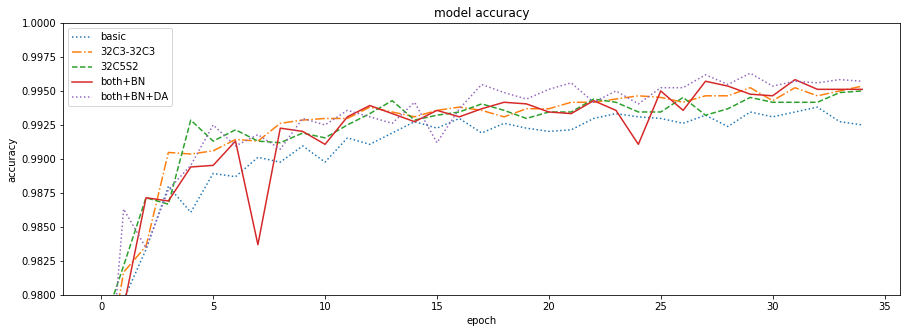

In [38]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i] )
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()